# 4. Data Exploration for the ArT dataset


In this notebook, we will take a look at the [ArT](https://rrc.cvc.uab.es/?ch=14) dataset which will be used for text detection and text recognition with EAST, CRNN, CRAFT and ASTER. Then, we will crop, the images to be used in text recognition by CRNN and ASTER.

**Table of Contents**

1. [Mount Google Drive](#mount-google-drive)
1. [ArT Dataset](#art-dataset)
1. [Prepare data for Text Detection or Spotting](#prepare-data-for-text-detection-or-spotting)
1. [Crop Word Image for Text Recognition](#crop-word-image-for-text-recognition)

Get your seatbelt on and let's get started! 🔥⭐


<a name="mount-google-drive"></a>
## Mount Google Drive

In [1]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd "/content/drive/My Drive"
%cd "ArT"
!ls

/content/drive/My Drive
/content/drive/My Drive/ArT
ArT.zip


In [3]:
!apt-get install unzip
!unzip ArT.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Archive:  ArT.zip
  inflating: selected/gt_1000.jpg    
  inflating: selected/gt_1031.jpg    
  inflating: selected/gt_1038.jpg    
  inflating: selected/gt_1042.jpg    
  inflating: selected/gt_1112.jpg    
  inflating: selected/gt_1153.jpg    
  inflating: selected/gt_1171.jpg    
  inflating: selected/gt_1402.jpg    
  inflating: selected/gt_354.jpg     
  inflating: selected/gt_378.jpg     
  inflating: selected/gt_392.jpg     
  inflating: selected/gt_398.jpg     
  inflating: selected/gt_450.jpg     
  inflating: selected/gt_465.jpg     
  inflating: selected/gt_506.jpg     
  inflating: selected/gt_513.jpg     
  inflating: selected/gt_529.jpg     
  inflating: selected/gt_582.jpg     
  inflating: selected/gt_683.jpg     
  inflating: selected/gt_684.jpg     
  infla

<a name="art-dataset"></a>
## ArT Dataset

In [4]:
import os
import cv2
import json
import random
import numpy as np
from PIL import Image, ImageDraw
import typing
from typing import List, Dict, Union
from google.colab.patches import cv2_imshow


def annoatate_img(
    anns: List[Dict[str, Union[str, List[int], bool]]], img: np.ndarray
):
    """Annotate an image given list of annotations

    Args:
        anns (List[Dict[str, Union[str, List[int], bool]]]): A list of dictionary with 'img', 'label', 'bbox', 'illegibility' as keys.
        img (np.ndarray): Original Image

    Returns:
        img (np.ndarray): Annotated image
    """

    for ann in anns:
      trans = ann['transcription']
      points = [tuple(x) for x in ann['points']]
      all_x = [x[0] for x in ann['points']]
      all_y = [x[1] for x in ann['points']]
      min_x = int(all_x[0] - 5)
      min_y = int(all_y[0] - 5)
      illegible = bool(ann['illegibility'])

      if illegible:
        outline_color = (0, 0, 255)
      else:
        outline_color = (0, 255, 0)

      cv2_points = np.array(ann['points'], np.int32).reshape(-1,1,2)
      cv2.polylines(img, [cv2_points], isClosed=True, color=outline_color, thickness=2)
      cv2.putText(img, trans, (min_x, min_y), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=outline_color, thickness=2, lineType=cv2.LINE_AA)

    return img


img_path = "/content/drive/My Drive/ArT/selected"
json_path = "/content/drive/My Drive/ArT/selected_labels.json"
all_files = os.listdir(img_path)
imgs = []

with open(json_path, mode='r') as in_json:
  data = json.load(in_json)


Displaying gt_761.jpg


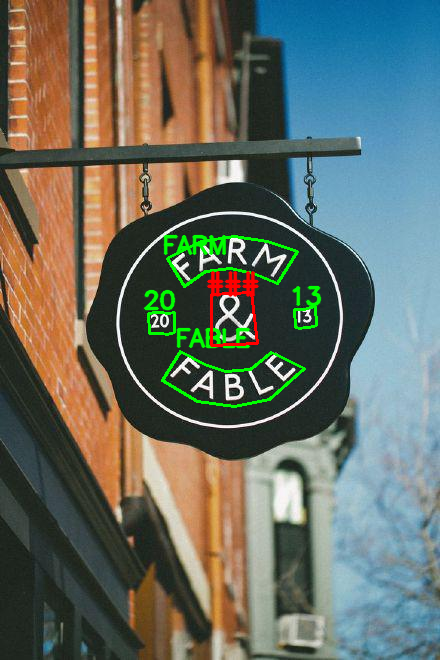

In [5]:
img_name = random.sample(all_files, 1)[0]
raw_img_name = os.path.splitext(os.path.basename(img_name))[0]

anns = data[raw_img_name]
img = cv2.imread(os.path.join(img_path, os.path.basename(img_name)))

img = annoatate_img(anns, img)

print(f'Displaying {img_name}')
cv2_imshow(img)

Displaying gt_1112.jpg


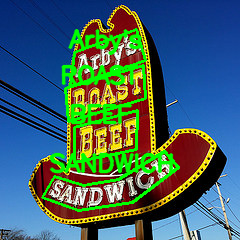

In [6]:
img_name = random.sample(all_files, 1)[0]
raw_img_name = os.path.splitext(os.path.basename(img_name))[0]

anns = data[raw_img_name]
img = cv2.imread(os.path.join(img_path, os.path.basename(img_name)))

img = annoatate_img(anns, img)

print(f'Displaying {img_name}')
cv2_imshow(img)

Displaying gt_766.jpg


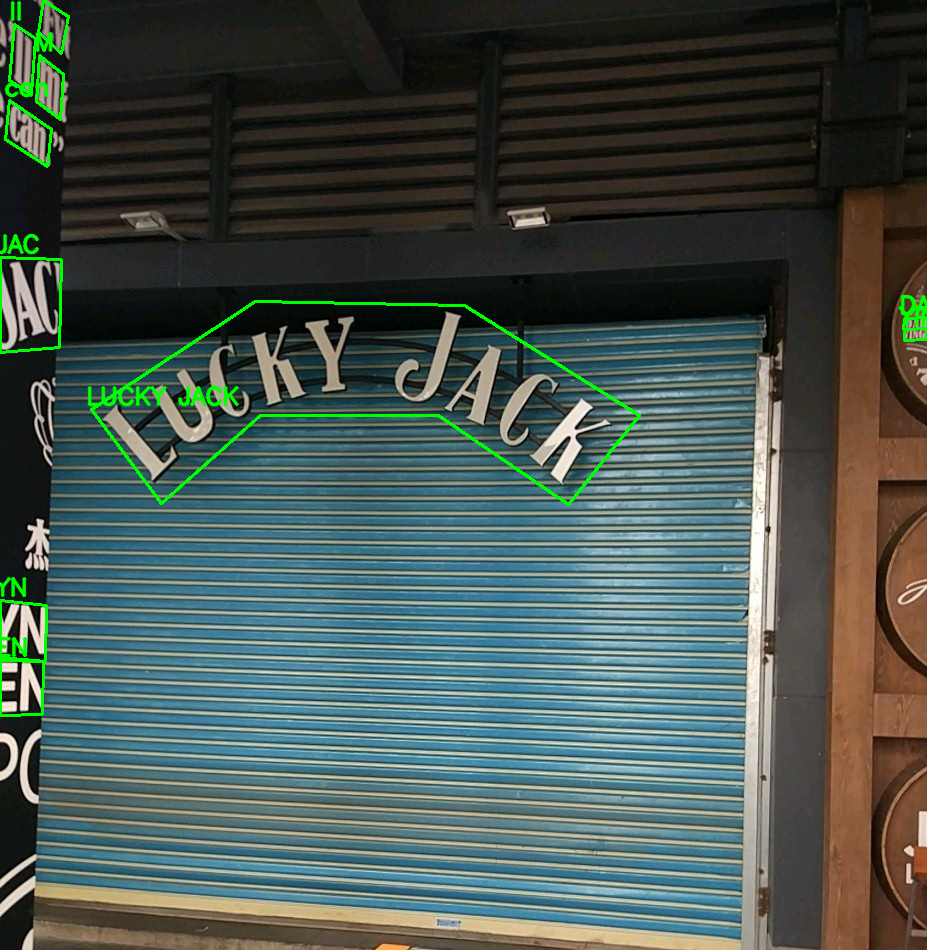

In [7]:
img_name = random.sample(all_files, 1)[0]
raw_img_name = os.path.splitext(os.path.basename(img_name))[0]

anns = data[raw_img_name]
img = cv2.imread(os.path.join(img_path, os.path.basename(img_name)))

img = annoatate_img(anns, img)

print(f'Displaying {img_name}')
cv2_imshow(img)

<a name="prepare-data-for-text-detection-or-spotting"></a>
## Prepare data for Text Detection or Spotting

In [8]:
# The following is PaddleOCR Format for text detection or text spotting
# " Image file name             Image annotation information encoded by json.dumps"
# ch4_test_images/img_61.jpg    [{"transcription": "MASA", "points": [[310, 104], [416, 141], [418, 216], [312, 179]]}, {...}]

In [9]:
import os
import json
from tqdm import tqdm


root_path = "/content/drive/My Drive/ArT/"
img_path = "/content/drive/My Drive/ArT/selected"
json_path = "/content/drive/My Drive/ArT/selected_labels.json"

all_files = os.listdir(img_path)
imgs = []

with open(json_path, mode='r') as in_json:
  data = json.load(in_json)

  all_files = os.listdir(img_path)
  all_files = sorted(all_files, key=lambda x: int(x.split('_')[1].replace('.jpg', '')))

  with open(root_path + f"det.txt", mode="w") as out_f:
      for img_name in tqdm(all_files):
          raw_img_name = os.path.splitext(os.path.basename(img_name))[0]
          anns = data[raw_img_name]
          
          ann_list = []
          for idx, ann in enumerate(anns):
            trans = ann['transcription']
            points = ann['points']
            illegible = bool(ann['illegibility'])

            if illegible:
              trans = '###'
            
            ann_list.append(
                {
                    "transcription": trans,
                    "points": ann['points'],
                }
            )
          out_f.write(f"{os.path.basename(img_name)}\t{json.dumps(ann_list)}\n")

100%|██████████| 50/50 [00:00<00:00, 7122.03it/s]


<a name="crop-word-image-for-text-recognition"></a>
## Crop Word Image for Text Recognition


In [10]:
# The following is PaddleOCR Format for text recognition
# " Image file name           Image annotation "
# train_data/rec/train/word_001.jpg   简单可依赖
# train_data/rec/train/word_002.jpg   用科技让复杂的世界更简单

In [11]:
import os
import cv2
import json
from tqdm import tqdm


root_path = "/content/drive/My Drive/ArT/"
img_path = "/content/drive/My Drive/ArT/selected"
json_path = "/content/drive/My Drive/ArT/selected_labels.json"
crop_out_path = "/content/drive/My Drive/ArT/selected_crop"

if not os.path.exists(crop_out_path):
    os.makedirs(crop_out_path)

all_files = os.listdir(img_path)
imgs = []

with open(json_path, mode='r') as in_json:
  data = json.load(in_json)

  all_files = os.listdir(img_path)
  all_files = sorted(all_files, key=lambda x: int(x.split('_')[1].replace('.jpg', '')))

  with open(root_path + f"rec.txt", mode="w") as out_f:
      for img_name in tqdm(all_files):
          raw_img_name = os.path.splitext(os.path.basename(img_name))[0]
          anns = data[raw_img_name]
          img = cv2.imread(os.path.join(img_path, os.path.basename(img_name)))

          for idx, ann in enumerate(anns):
            trans = ann['transcription']
            points = [tuple(x) for x in ann['points']]
            all_x = [x[0] for x in ann['points']]
            all_y = [x[1] for x in ann['points']]
            min_x = int(min(all_x))
            min_y = int(min(all_y))
            max_x = int(max(all_x))
            max_y = int(max(all_y))
            w = max_x - min_x
            h = max_y - min_y
            illegible = bool(ann['illegibility'])

            # crop image
            if not illegible and trans != '':
              current_img_name = raw_img_name+f'_{idx}.jpg'
              cropped = img[min_y:max_y, min_x:max_x].copy()
              cv2.imwrite(os.path.join(crop_out_path, current_img_name), cropped)
              out_f.write(f"{current_img_name}\t{trans}\n")

100%|██████████| 50/50 [00:02<00:00, 19.52it/s]
